In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # put -1 to not use any

In [2]:
import pickle
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import cv2
import torch
import SimpleITK as sitk

from  PIL  import  Image
from lang_sam import LangSAM

/home/lumargot/.conda/envs/langsam-v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
! pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 22.2 MB/s eta 0:00:0000:0100:01


In [4]:
img_path = '/CMF/data/lumargot/trachoma/PoPP_Data/mtss/img/12177_12Intra_os_postop.jpg'
seg_path = img_path.replace('img', 'seg').replace('.jpg', '.nrrd')

seg = torch.tensor(np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(seg_path)).copy())).to(torch.float32)
img = torch.tensor(np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(img_path)).copy())).to(torch.float32)
# img = img.permute((2, 0, 1))
img = img/255.0

## crop img within segmentation
bbx_eye = compute_eye_bbx(seg, pad=0.05)
img_cropped = img[bbx_eye[1]:bbx_eye[3],bbx_eye[0]:bbx_eye[2],:]
seg_cropped = seg[bbx_eye[1]:bbx_eye[3],bbx_eye[0]:bbx_eye[2] ]
seg_cropped[ seg_cropped!=3 ] =0
h,w = seg_cropped.shape


#### sort csv by True/Predictd segmentation ratio

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
def compute_eye_bbx(seg, label=1, pad=0):

    shape = seg.shape
    
    ij = torch.argwhere(seg.squeeze() != 0)

    bb = torch.tensor([0, 0, 0, 0])# xmin, ymin, xmax, ymax

    bb[0] = torch.clip(torch.min(ij[:,1]) - shape[1]*pad, 0, shape[1])
    bb[1] = torch.clip(torch.min(ij[:,0]) - shape[0]*pad, 0, shape[0])
    bb[2] = torch.clip(torch.max(ij[:,1]) + shape[1]*pad, 0, shape[1])
    bb[3] = torch.clip(torch.max(ij[:,0]) + shape[0]*pad, 0, shape[0])
    
    return bb

#### Crop eye region with LangSam

In [5]:
CHECKPOINT_PATH='/home/lumargot/SurgicalSAM/ckp/sam/sam_vit_h_4b8939.pth'
# DATA_DIR = 'B images one eye/B one eye 2870 onwards'


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LangSAM()

In [6]:
from torchvision.transforms.functional import to_pil_image

In [27]:
img_cropped.permute(2,0,1).shape

torch.Size([3, 2506, 3006])

Predicting 1 masks
Predicted 1 masks


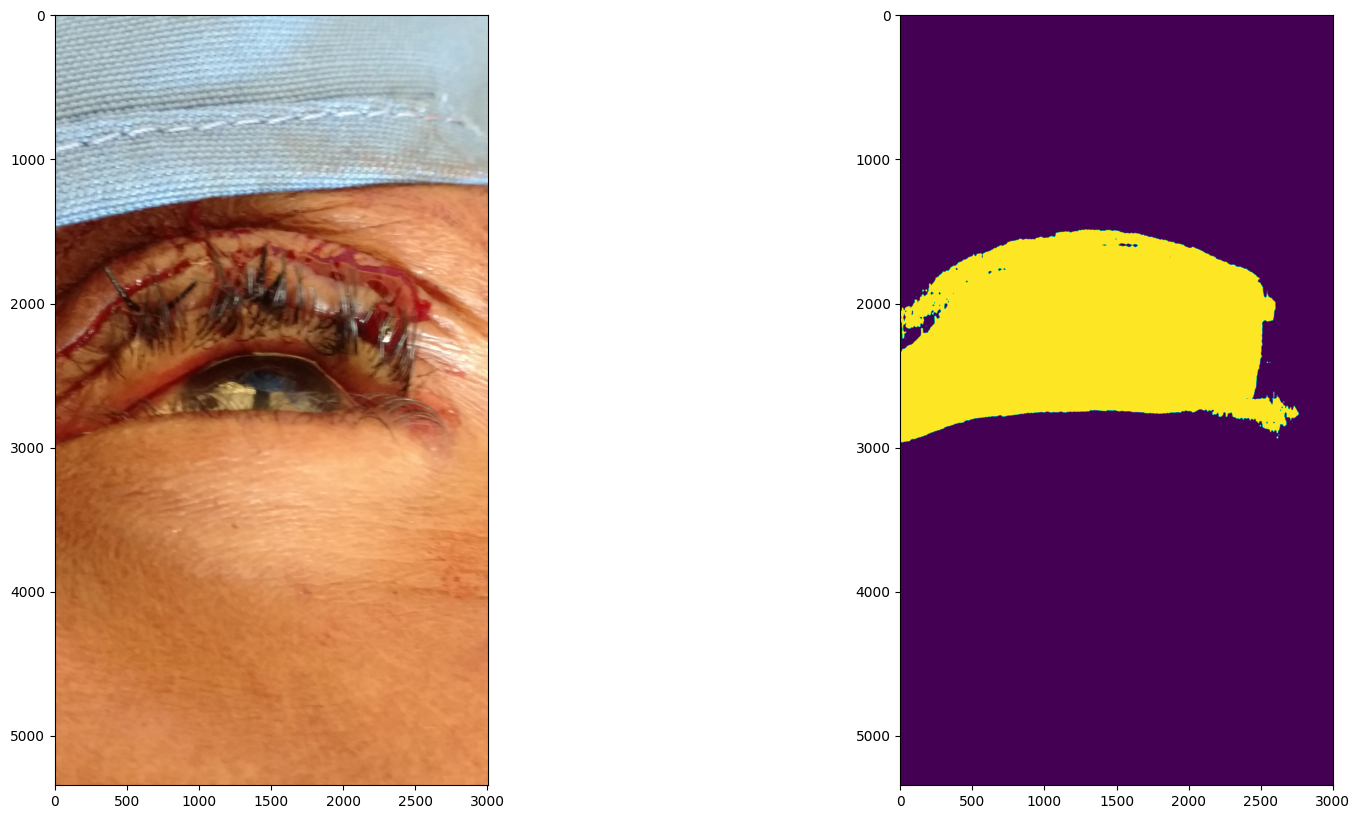

In [16]:
crop = to_pil_image(img.permute(2,0,1), mode=None)
out = model.predict([crop], ['eye lashes'])

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(out[0]['masks'][0])

Predicting 1 masks
Predicted 1 masks


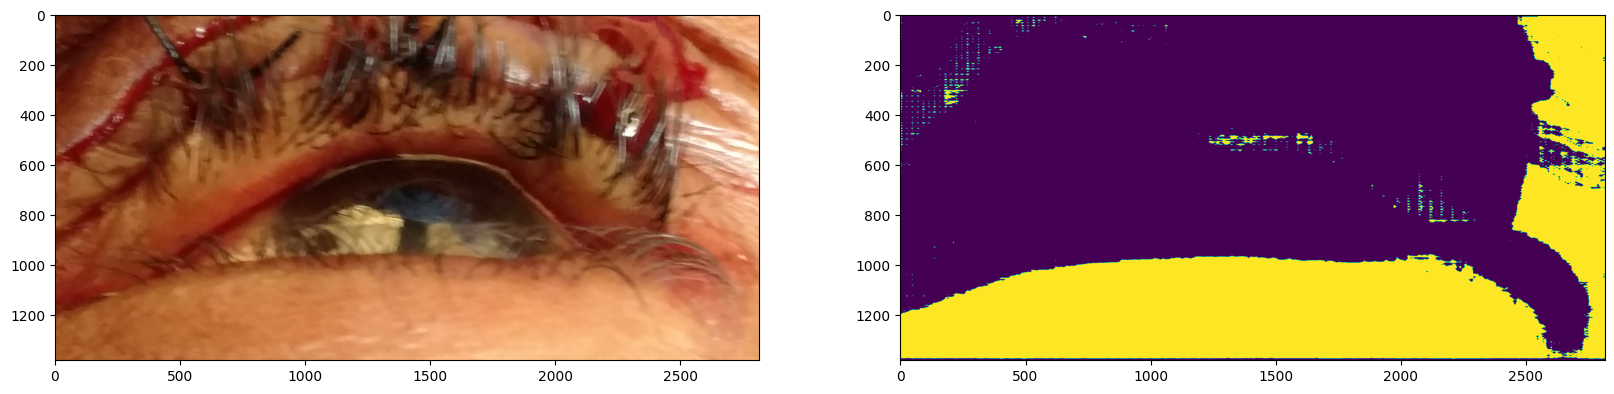

In [ ]:
crop = to_pil_image(img_cropped.permute(2,0,1), mode=None)
out = model.predict([crop], [''])

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img_cropped)
plt.subplot(122)
plt.imshow(out[0]['masks'][0])

In [ ]:
targets = []
crop_list = []
box_list = []

for img_name in os.listdir(DATA_DIR):
    
    img_path = os.path.join(DATA_DIR, img_name)
    targets.append(img_path)

save_dir = os.path.join(targets[0].split('B one eye 2870 onwards')[0], 'crop_mask')

i=0
text_prompt = 'eye'

for t in targets:
    print(f"Processing '{t}' : idx {i} / {len(targets)}")
    i+=1
    name = os.path.basename(t)

    np_im = cv2.imread(t)
    np_im = cv2.cvtColor(np_im, cv2.COLOR_BGR2RGB)

    h,w = np_im.shape[:2] 

    if np_im is None:
        print(f"Could not load '{t}' as an image, skipping...")
        continue
    out_path = os.path.join(save_dir, name)    
    im = Image.open(t)
    
    masks, boxes, labels, logits = model.predict(im, text_prompt)
    
    mask = masks[0]
    box = boxes[0]
    
    xmin,ymin, xmax, ymax = int(box[0].numpy()) -5, int(box[1].numpy()) -5 , int(box[2].numpy())+5 , int(box[3].numpy())+5
    
    
    cropped_img = np_im[ymin:ymax, xmin:xmax]

    crop_list.append(out_path)
    box_list.append(np.array([xmin, ymin, xmax, ymax]))


    cv2.imwrite(out_path,cropped_img)
    
    # plt.imshow(cropped_img)
    # plt.show()

failing cases -  eye closed, segmented other thing (i.e. nose), segmented nose or segmented eye of person in background

In [ ]:
df = pd.DataFrame(data={'img':targets, 'crop_img':crop_list, 'box':box_list})
df.to_csv('new_B_cropped_list.csv')